In [1]:
import os, shutil, subprocess, glob

import numpy as np
import scipy as sp
from scipy.io import loadmat

import cortex as cx
import bottleneck as bn

from scipy.ndimage import gaussian_filter, uniform_filter

from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

import matplotlib.pyplot as plt
%matplotlib inline

/tank/tkn219/projects/prfpy/prfpy/model.py:3: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [2]:
base_dir = '/scratch/2021/nprf_ss/derivatives/'
sjs = ['sub-01', 'sub-02']

### Finish preprocessing, average across runs

In [16]:
for sj in [0, 1]:
    for data_type, data_dir in zip(['denoised_bold', 'max_r2', 'preproc_bold'],['denoising', 'denoising', 'preproc']):
        h_files = [glob.glob(os.path.join(base_dir, 'pybest', sjs[sj], data_dir, f'{sjs[sj]}_task-prf_space-fsaverage_hemi-{hemi}_run-*_desc-{data_type}.npy')) for hemi in ['L', 'R']]
        print(np.array(h_files))

        def median_funcs_one_hemi(funcs):
            all_data = np.array([np.load(f) for f in funcs])
            all_data[all_data == 0] = np.nan
            return bn.nanmedian(all_data, 0)

        av_hemis = [median_funcs_one_hemi(funcs) for funcs in h_files]
        os.makedirs(os.path.join(base_dir, 'pybest', sjs[sj], 'median'), exist_ok=True)

        for i, hemi in enumerate(['L', 'R']):
            np.save(os.path.join(base_dir, 'pybest', sjs[sj], 'median', f'{sjs[sj]}_task-prf_space-fsaverage_hemi-{hemi}_run-median_desc-{data_type}.npy'), av_hemis[i])

[['/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-1_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-2_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-3_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-4_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-5_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-6_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsaverage_hemi-L_run-7_desc-denoised_bold.npy'
  '/scratch/2021/nprf_ss/derivatives/pybest/sub-01/denoising/sub-01_task-prf_space-fsavera

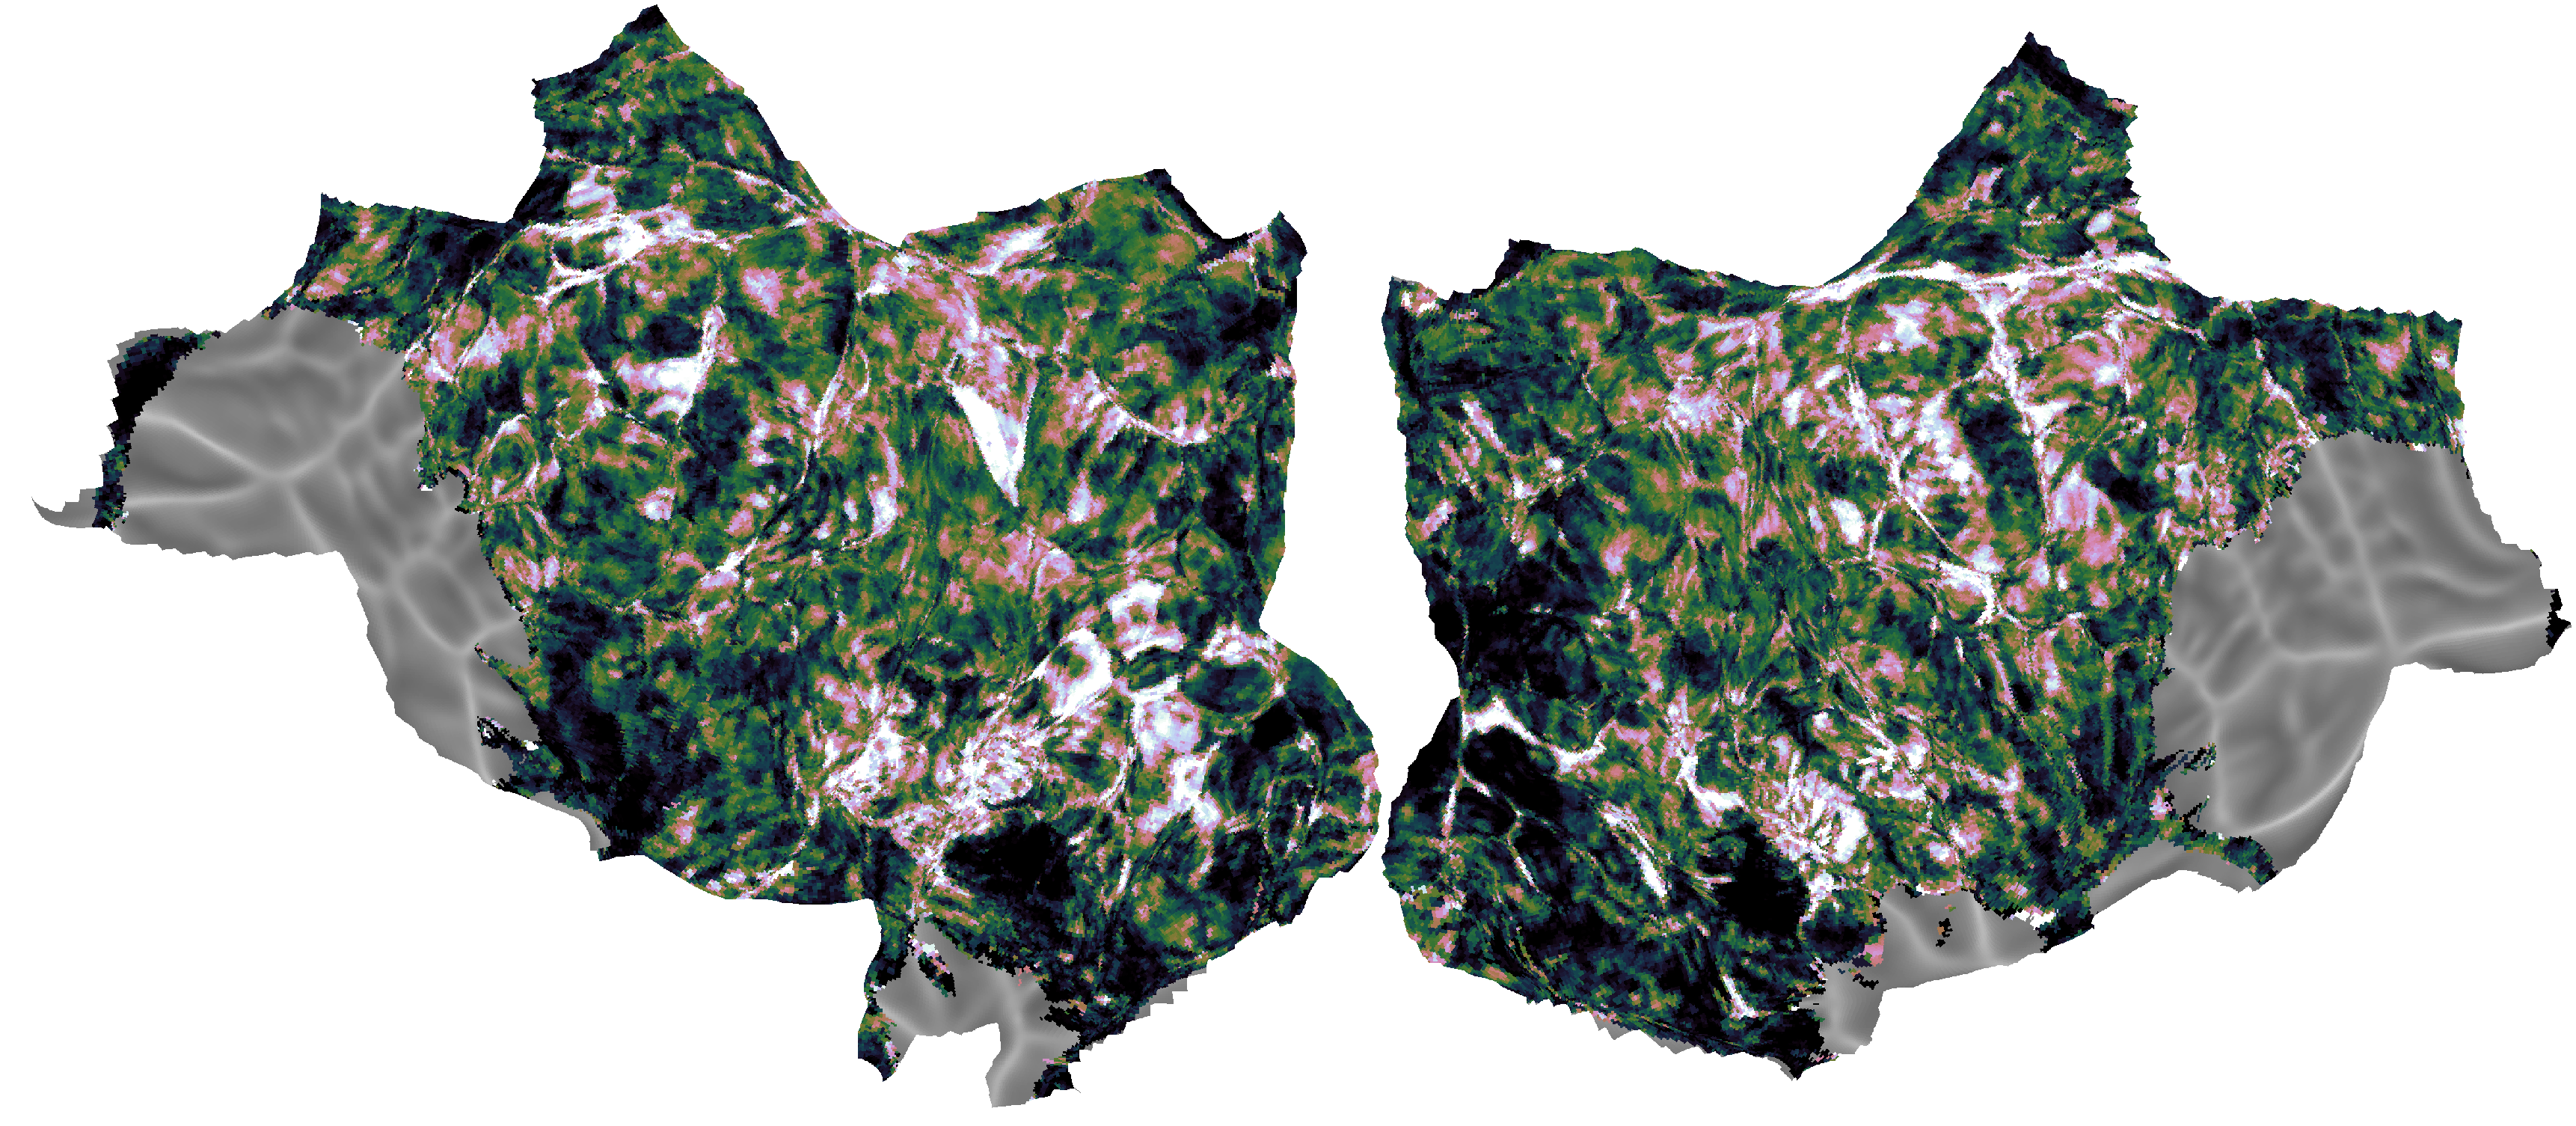

In [21]:
sj = 1
r2_data = np.concatenate([np.load(os.path.join(base_dir, 'pybest', sjs[sj], 'median', f'{sjs[sj]}_task-prf_space-fsaverage_hemi-{hemi}_run-median_desc-max_r2.npy')) for hemi in ['L', 'R']])
                  
rm_mr_v = cx.Vertex(r2_data, vmin=0, vmax=0.3, subject='fsaverage_tk',  cmap='cubehelix') # , vmin=0, vmax=0.5
f=cx.quickshow(rm_mr_v, 
               with_labels=False, 
               with_rois=False, 
               with_borders=False, 
               with_sulci=False, 
               with_colorbar=False, 
               height=2048, 
               with_curvature=True, 
               curvature_brightness=0.5,
               curvature_contrast=0.5,
               curvature_threshold=False);
f.savefig(os.path.join(base_dir, 'pybest', sjs[sj], 'median', 'rsq_median.pdf'))

### pRF fitting on denoised data

In [31]:
sj = 1
os.makedirs(os.path.join(base_dir, 'pybest', sjs[sj], 'prf'), exist_ok=True)

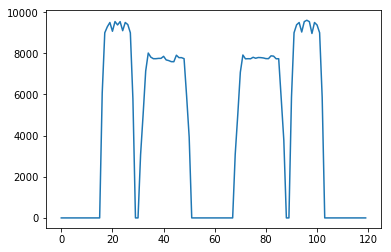

In [32]:
dms = loadmat('../data/vis_design.mat')['stim'].T

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = dms[timepoint]
    new_dms[timepoint,:,] = (uniform_filter(square_screen, 25) > 0.5).T

new_dms = new_dms[:,::2,::2]
# f, ss = plt.subplots(12,10, figsize=(30,30))
# shp = 0
# for i in range(12):
#     for j in range(10):
#         ss[i,j].imshow(new_dms[shp])
#         shp += 1
plt.figure()
plt.plot(new_dms.sum((1,2)))

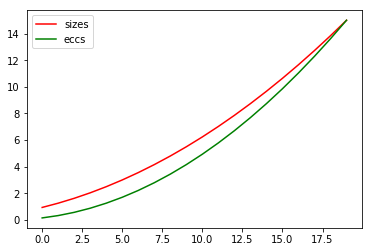

In [34]:
prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = 15
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

plt.plot(sizes, 'r', label='sizes')
plt.plot(eccs, 'g', label='eccs')
plt.legend()

gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=True,
                        filter_type='dc',
                        filter_params={'first_modes_to_remove': 3})

In [35]:
tc_data = np.nan_to_num(np.hstack([np.load(os.path.join(base_dir, 'pybest', sjs[sj], 'median', f'{sjs[sj]}_task-prf_space-fsaverage_hemi-{hemi}_run-median_desc-denoised_bold.npy')) for hemi in ['L', 'R']]).T)
print(tc_data.shape)

(327684, 120)


In [36]:
gf = Iso2DGaussianFitter(data=tc_data, model=gg, n_jobs=60, fit_hrf=False)
gf.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 pos_prfs_only=False)

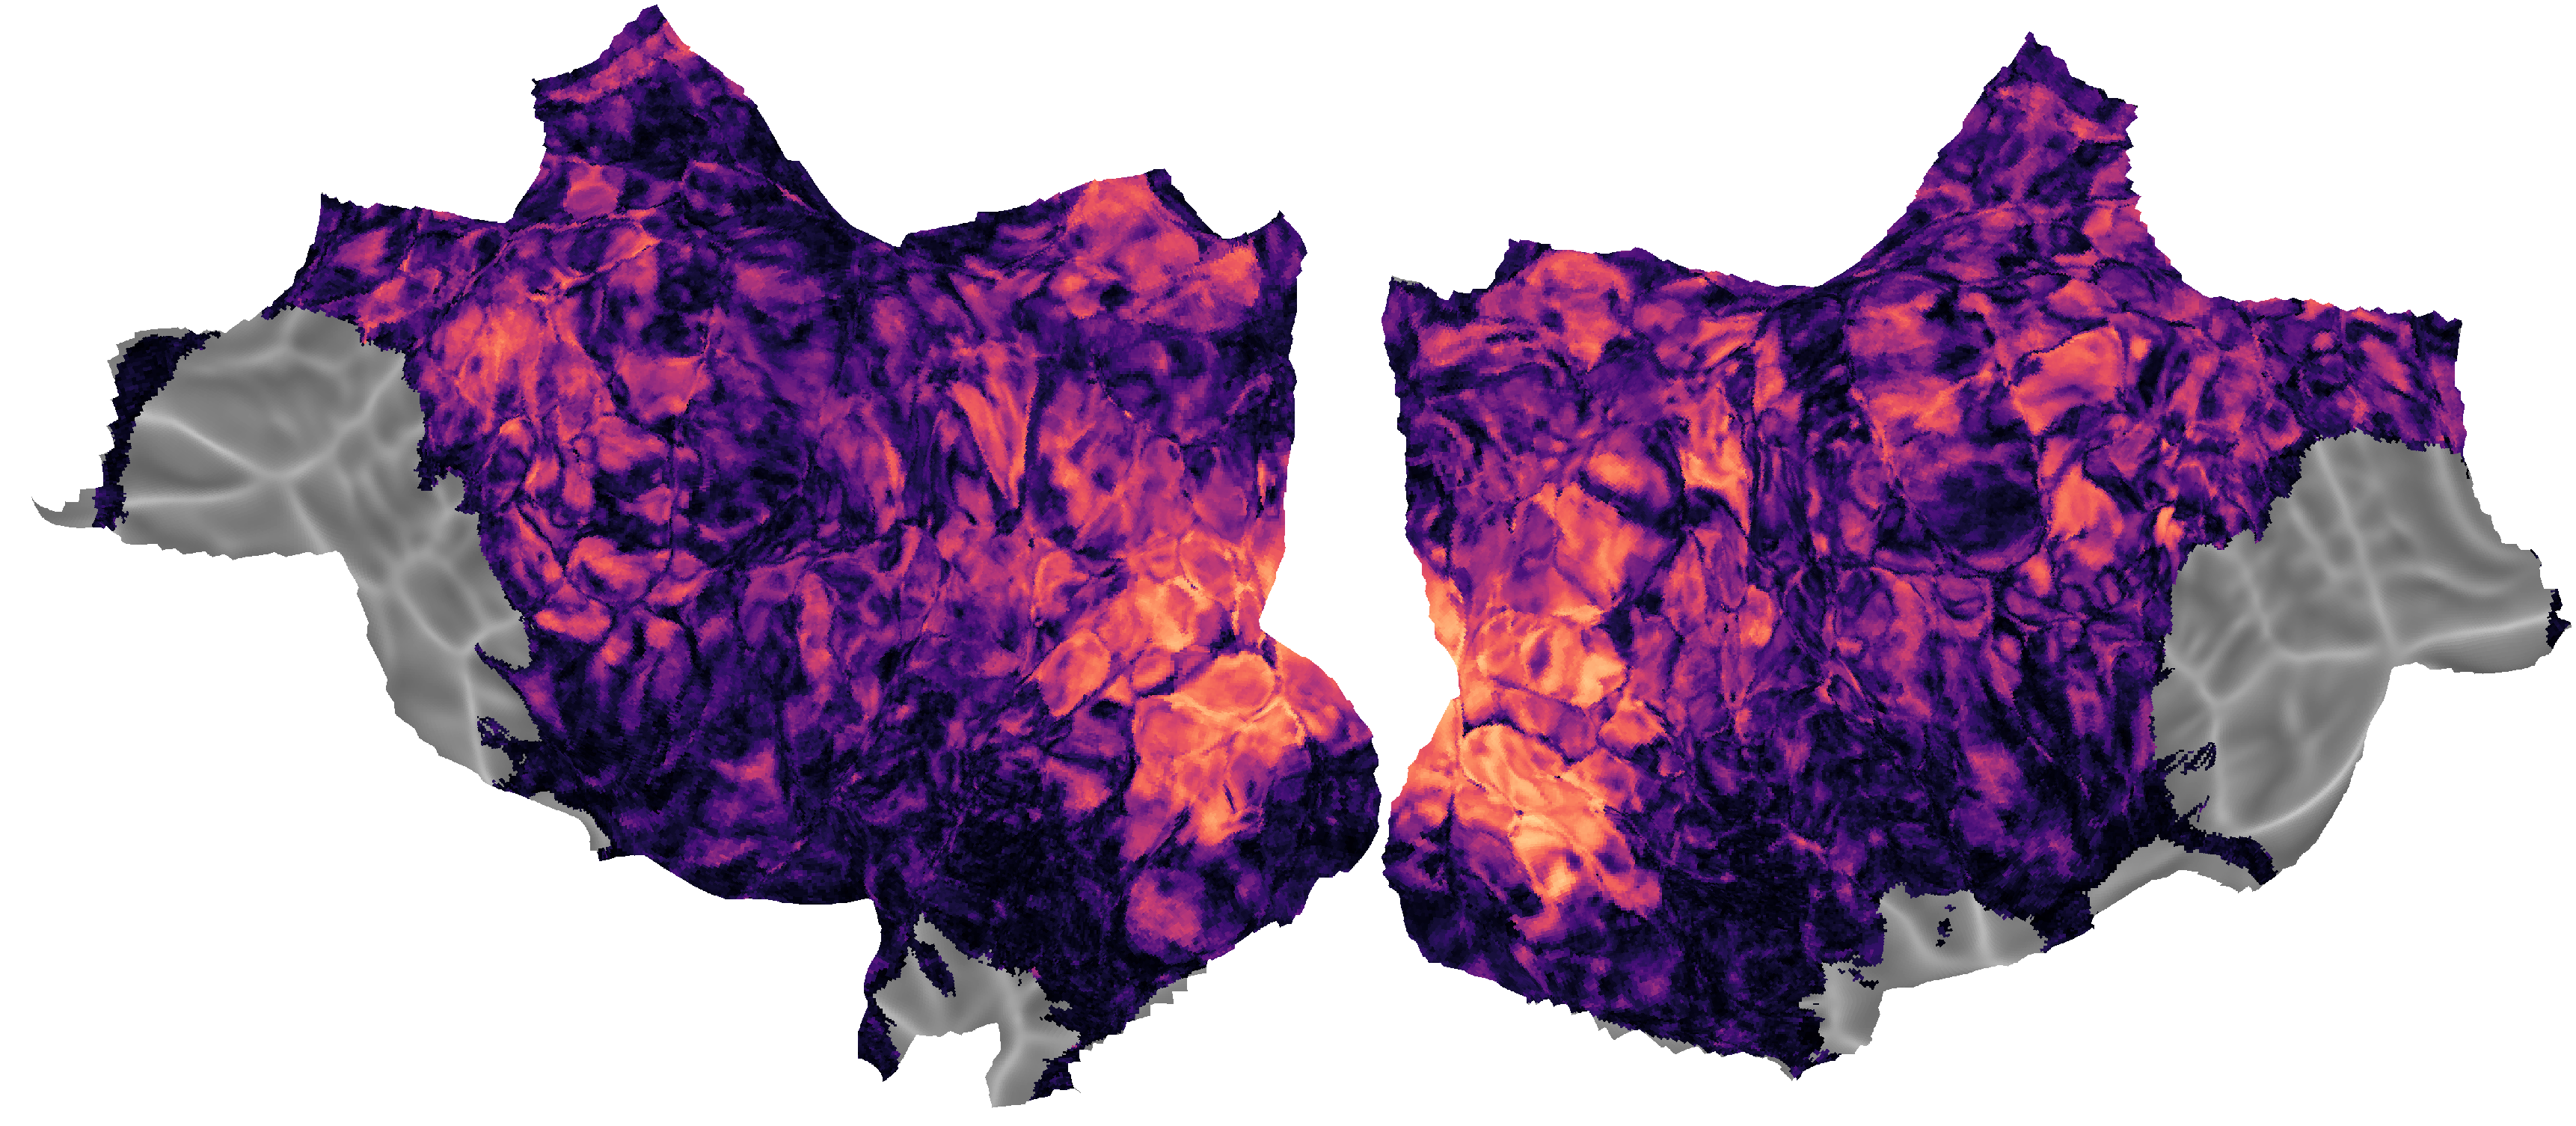

In [37]:
r2_data = gf.gridsearch_r2
                  
rm_mr_v = cx.Vertex(r2_data, vmin=0, vmax=1, subject='fsaverage_tk',  cmap='magma') # , vmin=0, vmax=0.5
f=cx.quickshow(rm_mr_v, 
               with_labels=False, 
               with_rois=False, 
               with_borders=False, 
               with_sulci=False, 
               with_colorbar=False, 
               height=2048, 
               with_curvature=True, 
               curvature_brightness=0.5,
               curvature_contrast=0.5,
               curvature_threshold=False);
f.savefig(os.path.join(base_dir, 'pybest', sjs[sj], 'prf', 'rsq_grid.pdf'))

In [ ]:
gf.fit_hrf = False
gf.iterative_fit(rsq_threshold=0.05, verbose=True)

/tank/tkn219/projects/prfpy/prfpy/fit.py:254: RuntimeWarning: invalid value encountered in greater
  self.rsq_mask = self.starting_params[:, -1] > rsq_threshold
[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:   20.9s
[Parallel(n_jobs=60)]: Done 330 tasks      | elapsed:   50.2s
[Parallel(n_jobs=60)]: Done 680 tasks      | elapsed:  1.5min
